In [1]:
# 读取数据
import json
with open('output/quantangshi.json',encoding='utf-8') as f:
    qtsdata = json.load(f)
print(qtsdata[0])

{'author': '太宗皇帝', 'paragraphs': ['秦川雄帝宅，函谷壯皇居。', '綺殿千尋起，離宮百雉餘。', '連甍遙接漢，飛觀迥凌虛。', '雲日隱層闕，風煙出綺疎。'], 'title': '帝京篇十首 一', 'id': '3ad6d468-7ff1-4a7b-8b24-a27d70d00ed4', 'tokenparas': ['秦 川 雄 帝 宅 ， 函 谷 壯 皇 居 。', '綺 殿 千 尋 起 ， 離 宮 百 雉 餘 。', '連 甍 遙 接 漢 ， 飛 觀 迥 凌 虛 。', '雲 日 隱 層 闕 ， 風 煙 出 綺 疎 。']}


In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 設置本地字體文件路徑
font_path = r'C:\Windows\Fonts\simkai.ttf'

# 使用FontProperties類來設置字體
custom_font = mpl.font_manager.FontProperties(fname=font_path)

# 設置Matplotlib的rcParams
plt.rcParams['font.sans-serif'] = custom_font.get_name()
mpl.rcParams['font.sans-serif'] = custom_font.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 防止坐标轴负号显示异常

In [3]:
# 查询包含某一个重言词的位置，输出总句数，标题和作者
def lookup_lines(word):
    lines = []
    for poem in qtsdata:
        title = poem['title']
        author = poem['author']
        for line in poem['paragraphs']:
            if word in line:
                lines.append(f'{line}——《{title}》{author}')
                
    print(f'{word}共{len(lines)}句。如下')
    for line in lines:
        print(line)
# word = '赫赫'
# lookup_lines(word)

In [4]:
# 查询包含多个词语的句子，输出句子、标题和作者
def lookup_lines_list(wordli,is_print = 1):
    lines = []
    for poem in qtsdata:
        title = poem['title']
        author = poem['author']
        for tokenpara in poem['tokenparas']:
            tokens = tokenpara.split()
            jiaoji = set(tokens) & set(wordli)
            if len(jiaoji) == len(wordli):
                line = tokenpara.replace(" ","")
                lines.append(f'{line}（{author}《{title}》）')
    if is_print == 1:            
        print(f'{" ".join(wordli)}共{len(lines)}句。如下')
        for line in lines:
            print(line)
    return lines

# wordli = ['皇','居']
# lookup_lines_list(wordli)

In [5]:
# 共现词频统计的基础工作
with open('output/quantangshi_token.txt','r',encoding= 'utf-8') as f:
    qtsli =[x.replace('\n',"") for x in f.readlines()] 
# print(qtsli[:10])
tokenized_corpus = [x.split() for x in qtsli]

import pickle,json,time
with open('output/chongyanlist.pkl', 'rb') as file:
    cy_set = list(pickle.load(file))

# 统计每一个词的共现词有哪些，以列表存储
from collections import defaultdict
cy_linedict = defaultdict(list)

for cyword in cy_set:
    for line in tokenized_corpus:
        if cyword in line:
            cy_linedict[cyword] = cy_linedict[cyword] + line
            
# 统计每个重言词的共现词的频次
from collections import Counter
cy_counter = {}
for cyword,cywordlines in cy_linedict.items():
    element_count = Counter(cywordlines)
    cy_counter[cyword] = element_count
# print(cy_counter['連連'])


In [6]:
# 生成共现词词云图
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random

def wordcloud(word,to_pic = 0):
    counter = cy_counter[word]
    for i in ['，','。','！','？']:
        if i in counter.keys():
            del counter[i]
        
    font_path = r'C:\Windows\Fonts\simkai.ttf'
    # 自定义颜色函数
    def custom_color_func(word, font_size, position, orientation, random_state, **kwargs):
        color_list = ['#3b6291', '#943c39', '#779043', '#624c7c','#388498', '#bf7334', '#3f6899', '#9c403d', '#7d9847', '#675083', '#3b8ba1', '#c97937']
        random_color = random.choice(color_list)
    
        return random_color  # 自定义16进制颜色码
    
    
    # 创建词云对象
    wordcloud = WordCloud(width=800, height=800,font_path=font_path, background_color='white',color_func=custom_color_func).generate_from_frequencies(counter)
    
    # 绘制词云
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # 关闭坐标轴
    plt.show()
    if to_pic == 1:
        wordcloud.to_file(f"output/{word}.png")
    print(counter)
    # return counter
# counter = wordcloud('皇皇')
# print(counter)

In [7]:
# 输入一个列表，生成这个列表所包含词语的位置分布图
import numpy as np
def li_position(wordli):
   # 初始化一个100维的向量，用于记录词语位置分布
    position_vector = np.zeros(100)
    for cy_word in wordli:
        word_lines = []
        for line in qtsli:
            if cy_word in line:
                line = line.replace(' ','')
                word_lines.append(line)
        # print(len(word_lines),word_lines[:10])
        
        # 遍历句子，记录词语位置分布
        for sentence in word_lines:
            if cy_word in sentence:
                start_position = sentence.index(cy_word)
                end_position = start_position + len(cy_word)
                start_percent = start_position / len(sentence) * 100
                end_percent = end_position / len(sentence) * 100
                position_vector[int(start_percent):int(end_percent)] += 1
            
    
    # 使用Matplotlib绘制热力图
    plt.figure(figsize=(15, 2))
    plt.imshow(position_vector.reshape(1, -1), cmap="YlGnBu", aspect="auto")
    plt.colorbar(label="词语出现次数")
    plt.xlabel("位置百分比")
    plt.title(f"{' '.join(wordli)}位置分布")
    plt.xticks(range(0, 100, 10), [f"{i}%" for i in range(0, 100, 10)])
    plt.yticks([])  # 隐藏Y轴
    plt.show()
   
# li_position(['蒼蒼'])

In [8]:
# 输入一个列表，输出列表词语的共同共现词的桑基图，并且打开这个页面
from pyecharts import options as opts
from pyecharts.charts import Sankey
import webbrowser,os
def sanjilist(wordli):
    countsli = [cy_counter[x] for x in wordli]
    countsumli = [sum(countsli[wordli.index(x)].values()) for x in wordli]
    
    # 找每两个词的共同共现词组合成一个交集
    intersation = set()
    for i in wordli:
        for j in wordli:
            if i == j:
                continue
            keys1 = countsli[wordli.index(i)].keys()
            keys2 = countsli[wordli.index(j)].keys()
            aintersation = set(keys1) & set(keys2)
            intersation = aintersation | intersation 
    print(intersation)
    
    # 找个词在所有词出现的总次数，如果低于某个阈值就不出现，形成一个交集
    intersation_gap = len(wordli)
    intersation2 = []
    bingji = []
    for i in wordli:
        gongxianwords = countsli[wordli.index(i)].keys()
        bingji += gongxianwords
    # print(bingji)
    bingjicount = [0] * len(bingji)
    for i in wordli:
        for ind,j in enumerate(bingji):
            bingjicount[ind] += countsli[wordli.index(i)][j]
    # print(bingjicount)
    for i in range(len(bingji)):
        gongxianword = bingji[i]
        if gongxianword in  ['，','。','！','？']:
            continue
        if bingjicount[i] <= intersation_gap:
            continue
        intersation2.append(gongxianword)
    print(intersation2)
    
    # 找同时满足两个条件的共现词
    intersation = list(intersation & set(intersation2))
    print(intersation)
    
    for i in wordli:
        if i not in intersation:
            intersation.append(i)
        
    # 生成节点和边
    nodes = []
    for label in intersation:
        nodes.append({'name':label})   
    
    links = []
    for ind,word in enumerate(wordli):
        for gongxianword in intersation:
            if gongxianword in wordli:
                if wordli.index(gongxianword) <= ind:
                    continue
            conuts = countsli[wordli.index(word)]
            value = conuts[gongxianword]
            lines = lookup_lines_list([word,gongxianword],is_print = 0)
            tooltip = "{}-{}({}):<br/>{}".format(word,gongxianword,len(lines),'<br/>'.join(lines))
            if value != 0:
                links.append({'source':word,'target':gongxianword,'value':value, 'tooltip':tooltip })
            
            
            
    # print(links[-1])
    
    # 生成桑基图
    sankey = (
        Sankey()
        .add(
            "",
            nodes,
            links,
            orient ="vertical",
            node_gap = 5,
            linestyle_opt=opts.LineStyleOpts(opacity=0.3, curve=0.5, color="source",type_="dotted"),
            label_opts=opts.LabelOpts(position="top",),
        )
        .set_global_opts(title_opts=opts.TitleOpts(title=f"{' '.join(wordli)}共同共现词"),)
    )
    # 保存图表为 HTML 文件
    filename = f"output/{' '.join(wordli)}共现词.html"
    sankey.render(filename)  
    path = os.path.abspath(filename)
    url = 'file://' + path
    webbrowser.open(url)

    
# wordli = ['粲粲', '皇皇' ]
# sanjilist(wordli)

In [9]:
from gensim.models import KeyedVectors

# 读取词向量文件
path = 'output\quantangshi_emb.txt'
emb = KeyedVectors.load_word2vec_format(path, binary=False, unicode_errors='ignore')
print(emb)

# 定义和执行查找最近邻
def near_c(word):
    # 找最近的重言词
    simi_words = emb.most_similar(word, topn=200)
    simi_words_c = []
    for w in simi_words:
        if len(w[0]) == 2:
            #print(w)
            simi_words_c.append(w)
    return simi_words_c

def near(word):
    #找最近的词
    simi_words = emb.most_similar(word, topn=20)
    #for w in simi_words:
        #print(w)
    return simi_words


KeyedVectors<vector_size=100, 5504 keys>


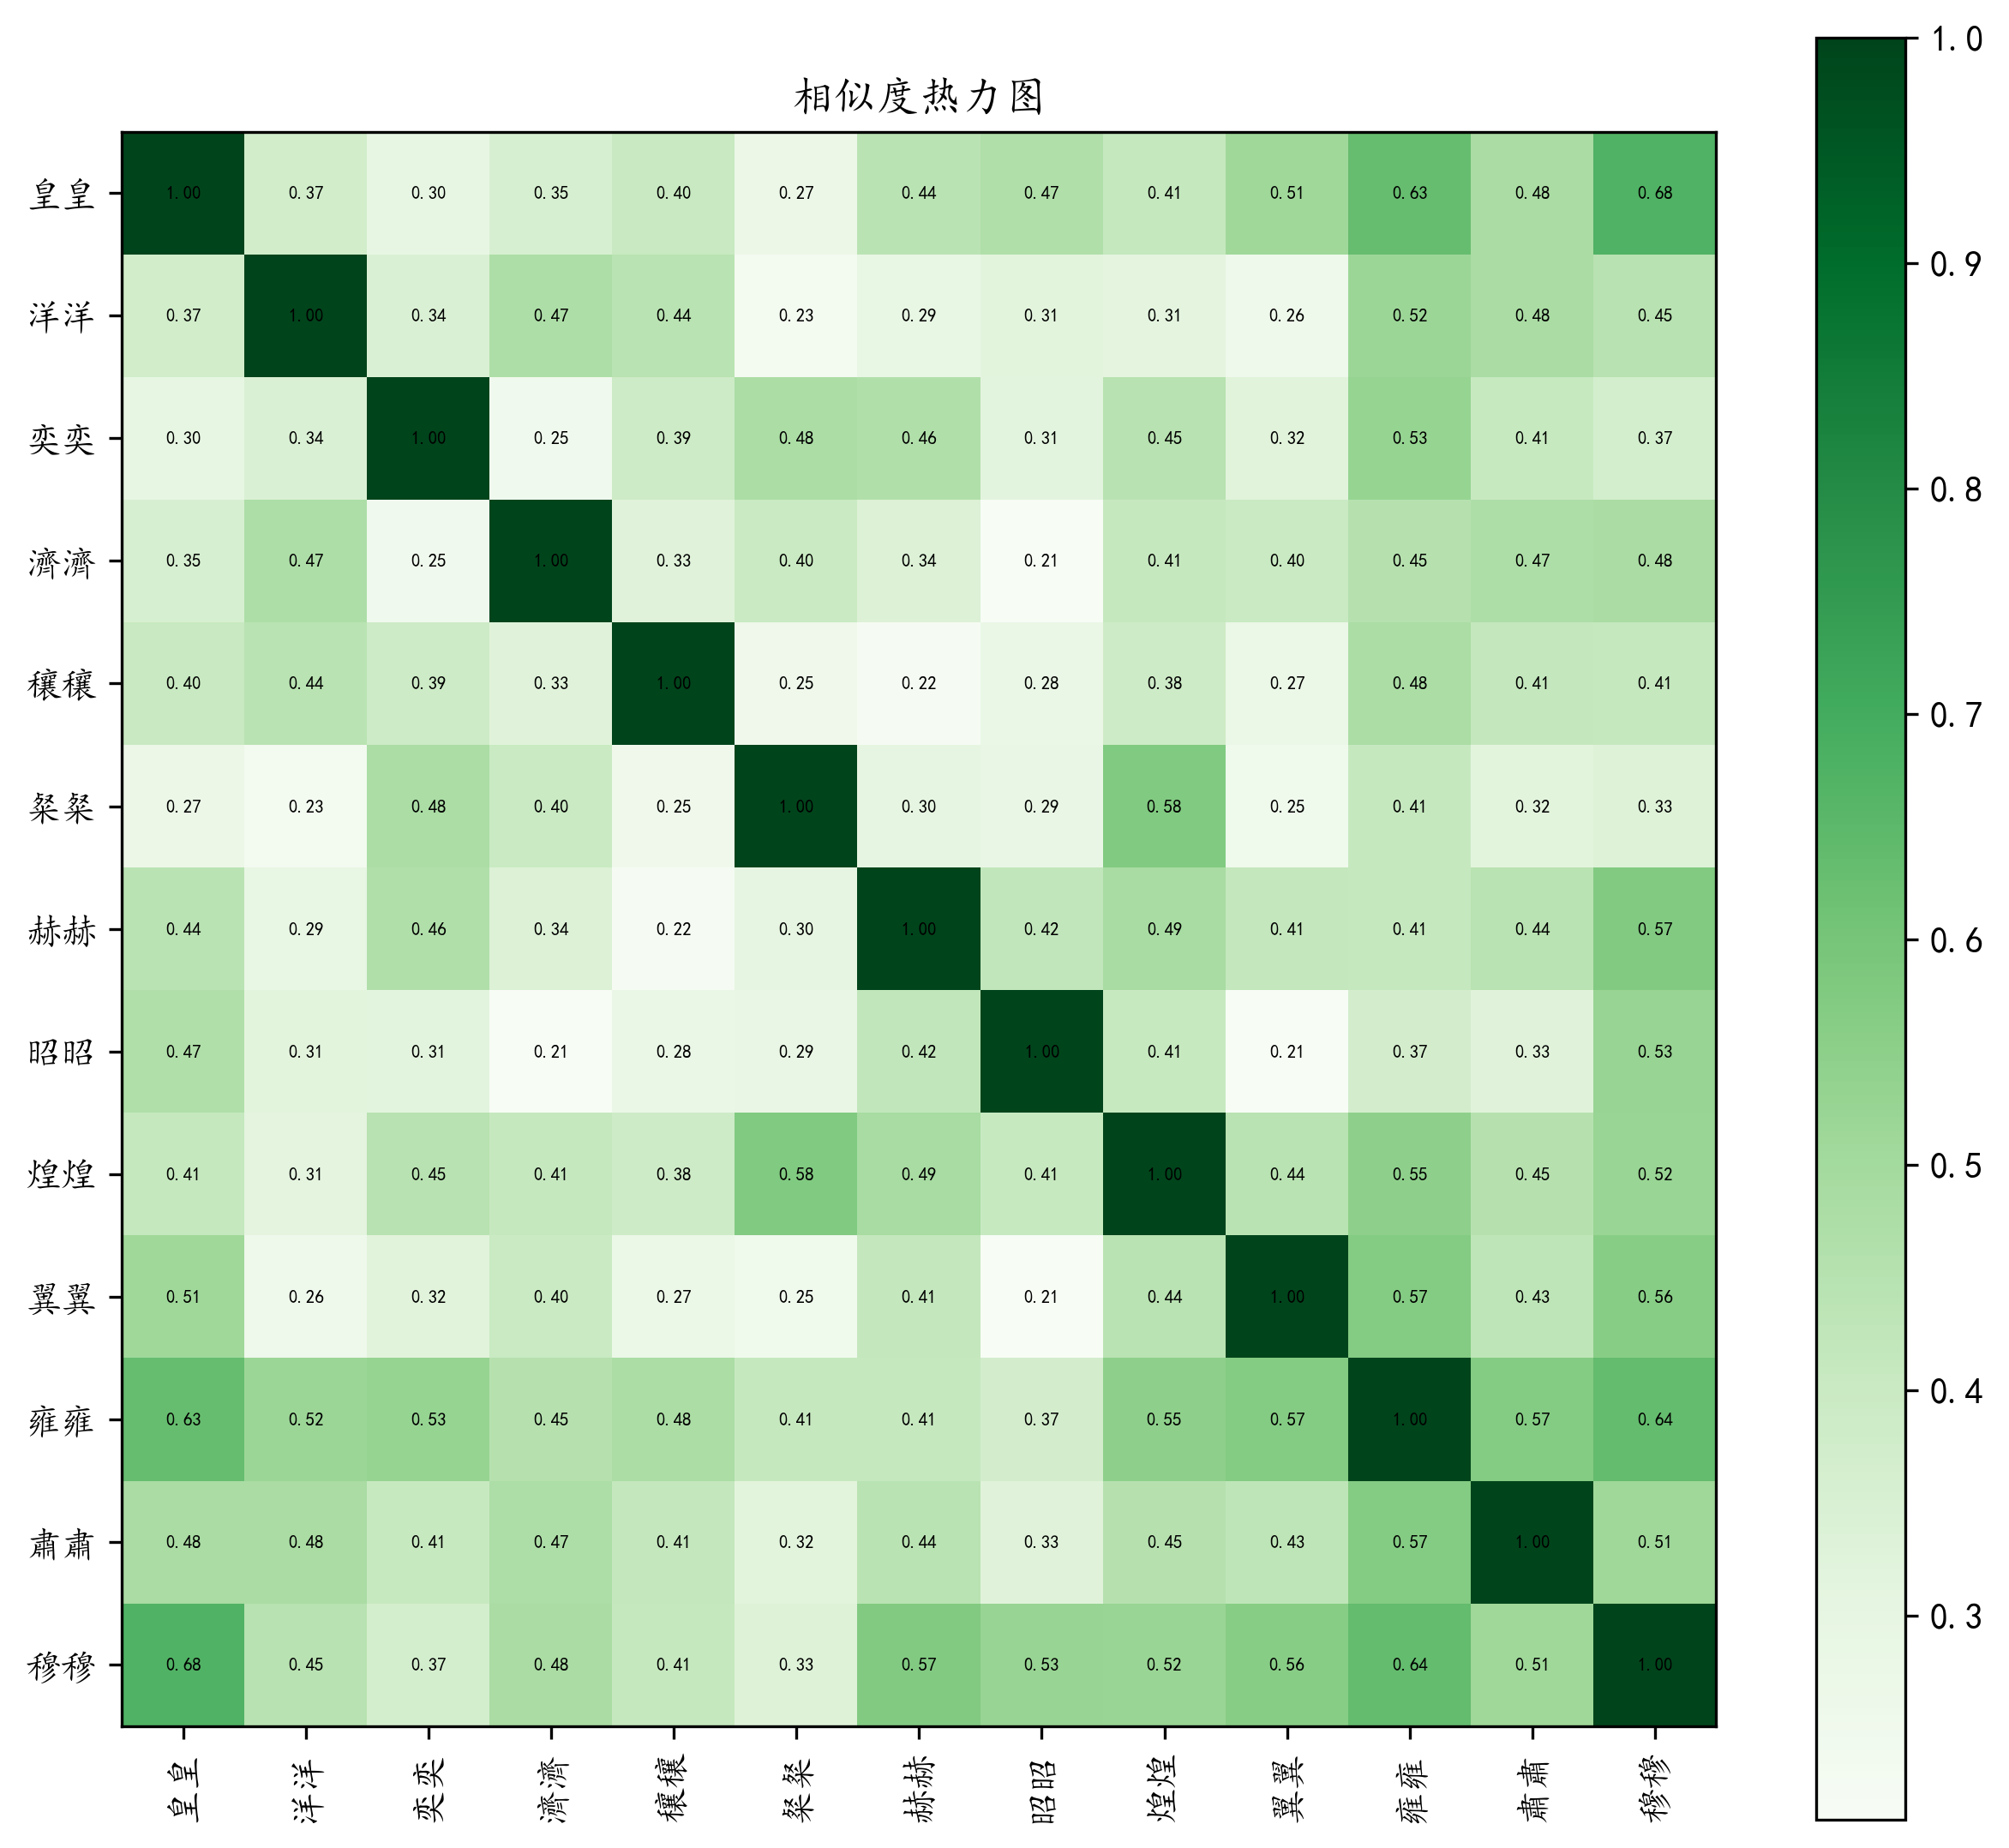

In [10]:
# 比較江西各人與各人，江西與其他代表詩人的相似度
from gensim.models import KeyedVectors
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def hotmap(duibili,cmapcolor,title="相似度熱力圖"):
    similarity_matrix = np.zeros((len(duibili), len(duibili)))

    for i, word1 in enumerate(duibili):
        for j, word2 in enumerate(duibili):
            if i <= j:  # 因为余弦相似度矩阵是对称的，所以只需计算上三角部分
                similarity = emb.similarity(word1, word2)
                similarity_matrix[i, j] = similarity
                similarity_matrix[j, i] = similarity  # 对称位置也设置为相似度值

    # print(similarity_matrix)
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10, 9), dpi=300)
    plt.imshow(similarity_matrix, cmap=cmapcolor, interpolation='nearest')
    # 添加相似度值的标签
    for i in range(len(duibili)):
        for j in range(len(duibili)):
            plt.annotate(f"{similarity_matrix[i, j]:.2f}", (j, i), color='black', ha='center', va='center',fontsize=5)
            
    plt.colorbar()
    plt.xticks(range(len(duibili)), [x for x in duibili], rotation=90)
    plt.yticks(range(len(duibili)), [x for x in duibili])
    plt.title(title)
    plt.savefig(f'output/{title}.png', dpi=300)

    plt.show()

duibili = ['皇皇', '洋洋' ,'奕奕', '濟濟', '穰穰' ,'粲粲' ,'赫赫' ,'昭昭', '煌煌' ,'翼翼' ,'雍雍','肅肅','穆穆']

hotmap(duibili,'Greens',title='相似度热力图')

In [11]:
doc1 = '肅肅 煌煌 赫赫 穆穆 濟濟 鏘鏘 皇皇 洋洋 凜凜 愔愔 穰穰 炎炎 奕奕 烈烈 英英 永永 粲粲 亹亹 鬱鬱 溫溫 雍雍 翼翼 婉婉'.split()
doc2 = '粲粲 皇皇 赫赫 翼翼 雍雍 洋洋 肅肅 穆穆 炎炎 奕奕 馥馥 昭昭 煌煌'.split()
both = set(doc1) & set(doc2)
print(both)
alll = set(doc1 + doc2)
print(alll)
print(alll - set(doc1))
print(alll - set(doc2))


{'赫赫', '雍雍', '穆穆', '洋洋', '皇皇', '粲粲', '肅肅', '煌煌', '炎炎', '奕奕', '翼翼'}
{'穆穆', '亹亹', '烈烈', '溫溫', '濟濟', '雍雍', '昭昭', '奕奕', '皇皇', '永永', '馥馥', '穰穰', '肅肅', '炎炎', '煌煌', '鬱鬱', '翼翼', '鏘鏘', '赫赫', '洋洋', '凜凜', '粲粲', '愔愔', '婉婉', '英英'}
{'馥馥', '昭昭'}
{'英英', '亹亹', '永永', '凜凜', '愔愔', '婉婉', '穰穰', '烈烈', '溫溫', '濟濟', '鬱鬱', '鏘鏘'}


In [12]:
# doc = ""
# 
# for ind,poem in enumerate(qtsdata):
#     paras = "".join(poem['paragraphs'])
#     doc = doc + paras + "\n"
#     if ind % 100 == 0:
#         print(ind,paras)
# with open(r'output\quantangshi_zhengwen.txt','w',encoding='utf-8') as f:
#     f.write(doc)

In [13]:
import pyperclip as pc
def lookup_quanwen(word):
    lines = []
    for poem in qtsdata:
        title = poem['title']
        author = poem['author']
        for line in poem['paragraphs']:
            if word in line:
                lines.append(f'“{line[:-1]}”（{author}《{title}》）')
                    
    print(f'{word}共{len(lines)}句。如下')
    for line in lines:
        print(line)
        pc.copy(line)
        
lookup_quanwen('蕭蕭望林夜')

蕭蕭望林夜共1句。如下
“蕭蕭望林夜，寂寂坐中秋”（不詳《雜曲歌辭 陸州 歌第二》）


In [14]:
# 尋找一個單字經常搭配的二元組
import re
from collections import Counter

def find_word_bigrams(corpus, word):
    pattern = r'[\u4e00-\u9fa5]'
    words = re.findall(pattern, corpus)

    # 构建二元组列表
    bigrams = [(words[i], words[i+1]) for i in range(len(words)-1) if word in (words[i], words[i+1])]

    # 统计二元组出现次数
    counter = Counter(bigrams)

    # 按出现次数排序并返回结果列表
    sorted_bigrams = sorted(counter.items(), key=lambda x: x[1], reverse=True)
    return sorted_bigrams


# with open(r'output\quantangshi_zhengwen.txt','r',encoding='utf-8') as f:
#     corpus = f.read()
# 
# # 查找包含字的二元组并按出现次数排序
# word = '蕭'
# result = find_word_bigrams(corpus, word)
# 
# # 打印结果列表
# num = 0
# for bigram, count in result:
#     print(f"{bigram}: {count}")
#     num +=1
#     if num >20 :
#         break

# 调用

蕭蕭共377句。如下
但飛蕭蕭雨，中有亭亭魂。——《鼓吹曲辭 巫山高二首 二》孟郊
落日照大旗，馬鳴風蕭蕭。——《橫吹曲辭 後出塞五首 二》杜甫
琵琶弦中苦調多，蕭蕭羌笛聲相和。——《相和歌辭 王昭君》劉長卿
蕭蕭煙雨九原上，白楊青松葬者誰。——《相和歌辭 短歌行》僧皎然
況臨松日暮，悲吹坐蕭蕭。——《相和歌辭 銅雀妓》袁暉
至今丁令塞，朔吹空蕭蕭。——《相和歌辭 從軍行 二》僧皎然
邊風蕭蕭，榆葉初落。——《相和歌辭 胡無人行》僧貫休
迴眸轉袖暗催弦，涼風蕭蕭流水急。——《舞曲歌辭 白紵辭二首 二》楊衡
朔風蕭蕭寒日暮，星河寥落胡天曉。——《琴曲歌辭 胡笳十八拍 第八拍》劉商
何處秋風至？蕭蕭送鴈羣。——《琴曲歌辭 秋風引》劉禹錫
鳶飛杳杳青雲裏，鳶鳴蕭蕭風四起。——《琴曲歌辭 飛鳶操》劉禹錫
海風蕭蕭天雨霜，窮愁獨坐夜何長？——《雜曲歌辭 出門行二首 二》孟郊
陋卷蕭蕭風淅淅，緬想斯人勝珪璧。——《雜曲歌辭 君子有所思行 一》僧貫休
木落蕭蕭，蛩鳴唧唧。——《雜曲歌辭 輕薄篇二首 二》僧貫休
蕭蕭邊馬思，獵獵戍旗閑。——《雜曲歌辭 昔昔鹽 一去無還意》趙嘏
蕭蕭望林夜，寂寂坐中秋。——《雜曲歌辭 陸州 歌第二》不詳
凜凜邊風急，蕭蕭征馬煩。——《出塞》虞世南
烈烈焚青棘，蕭蕭吹白楊。——《過漢故城》王績
蕭蕭離俗影，擾擾望鄉心。——《出境遊山二首 二》王勃
蕭蕭度閶闔，習習下庭闈。——《詠風》董思恭
雲山一一看皆美，竹樹蕭蕭畫不成。——《扈從鄠杜間奉呈刑部尚書舅崔黃門馬常侍》蘇頲
憫憫琴上鶴，蕭蕭路傍馬。——《餞許州宋司馬赴任》馬懷素
烈烈樊青棘，蕭蕭吹白楊。——《過漢故城》吳少微
湛湛山川暮，蕭蕭涼氣稀。——《送盧管記仙客北伐》沈佺期
秋風將客思，川上晚蕭蕭。——《廣陵送別宋員外佐越鄭舍人還京》韋述
秋風將客思，川上晚蕭蕭。——《還京》張諤
蕭蕭牧馬鳴，中夜拔劒起。——《從軍》劉庭琦
況臨松日暮，悲吹坐蕭蕭。——《銅雀妓》袁暉
邊樹蕭蕭不覺春，天山漠漠長飛雪。——《從軍行》賀朝
更聞金剎下，鐘梵晚蕭蕭。——《立秋日題安昌寺北山亭》孫逖
靡靡俗中理，蕭蕭川上幽。——《寄萬齊融》李頎
北風何蕭蕭，茲夕露爲霜。——《秋山寄陳讜言》王昌齡
暗覺海風度，蕭蕭聞鴈飛。——《太湖秋夕》王昌齡
蕭蕭若凌虛，衿帶頃消靡。——《贈宇文中丞》王昌齡
落日未能別，蕭蕭林木虛。——《送

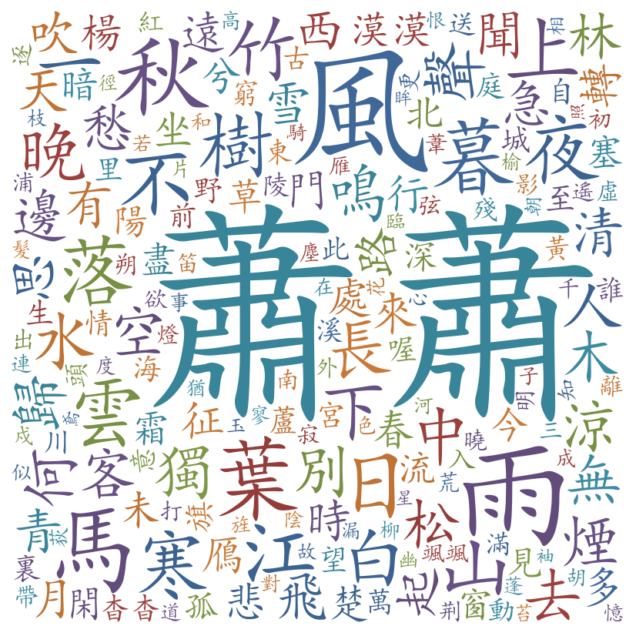

Counter({'蕭蕭': 376, '風': 109, '雨': 78, '秋': 42, '馬': 39, '葉': 35, '日': 34, '暮': 32, '落': 28, '不': 28, '雲': 27, '江': 27, '上': 26, '夜': 26, '山': 26, '樹': 26, '寒': 25, '竹': 24, '白': 21, '晚': 21, '一': 20, '聲': 19, '水': 19, '長': 19, '下': 19, '中': 17, '鳴': 16, '煙': 16, '何': 16, '獨': 16, '人': 16, '松': 15, '空': 15, '涼': 15, '木': 15, '歸': 15, '去': 15, '邊': 14, '客': 14, '別': 14, '無': 14, '飛': 13, '天': 13, '愁': 13, '林': 13, '聞': 13, '清': 13, '有': 12, '青': 12, '吹': 12, '急': 12, '起': 12, '思': 12, '路': 12, '雪': 12, '西': 12, '時': 12, '轉': 11, '征': 11, '行': 11, '月': 11, '門': 11, '來': 11, '遠': 11, '多': 10, '楊': 10, '悲': 10, '坐': 10, '處': 10, '鴈': 10, '春': 10, '漠漠': 10, '北': 10, '未': 10, '楚': 10, '兮': 10, '今': 9, '塞': 9, '暗': 9, '流': 9, '霜': 9, '閑': 9, '盡': 9, '草': 9, '陽': 9, '見': 9, '窗': 9, '深': 9, '孤': 9, '旗': 8, '至': 8, '杳杳': 8, '裏': 8, '海': 8, '望': 8, '庭': 8, '野': 8, '宮': 8, '自': 8, '情': 8, '入': 8, '里': 8, '此': 8, '蘆': 8, '城': 8, '生': 8, '喔': 8, '誰': 7, '送': 7, '窮': 7, '川': 7, '動': 7, '東': 7, '黃': 7

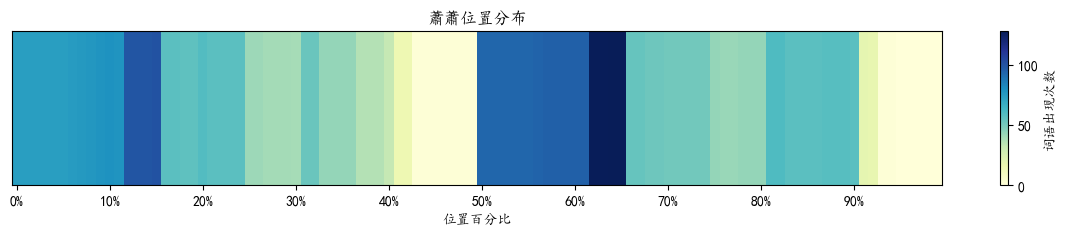

In [13]:
# 调用示例
word = '蕭蕭'
lookup_lines(word)

# wordli = ['皇','居']
# lookup_lines_list(wordli)

wordcloud(word)

li_position([word])

# wordli = ['粲粲', '皇皇' ,'赫赫', '翼翼', '雍雍' ,'洋洋' ,'肅肅' ,'穆穆', '奕奕' ,'昭昭' ,'煌煌','濟濟','穰穰']
# wordli = ['粲粲','赫赫','昭昭','煌煌']
# wordli = ['皇皇','洋洋','奕奕','濟濟','穰穰']
# wordli = ['翼翼','雍雍','肅肅','穆穆']
# sanjilist(wordli)

In [28]:
lookup_lines_list(['濛濛','雨'])

濛濛 雨共43句。如下
細雨濛濛溼芰荷，巴東商侶挂帆多。（楊巨源《相和歌辭 大堤曲》）
華陽洞口片雲飛，細雨濛濛欲濕衣。（儲光羲《題茅山華陽洞》）
微雨隨雲收，濛濛傍山去。（王昌齡《山行入涇州》）
仙老言餘鶴飛去，玉清壇上雨濛濛。（王昌齡《武陵龍興觀黃道士房問易因題》）
鬱鬱冬炎瘴，濛濛雨滯淫。（杜甫《風疾舟中伏枕書懷三十六韻奉呈湖南親友》）
日長巴峽雨濛濛，又說歸舟路未通。（戎昱《雲安阻雨》）
簫管曲長吹未盡，花南水北雨濛濛。（盧綸《曲江春望 二》）
落日鳳城佳氣合，滿城春樹雨濛濛。（章八元《題慈恩寺塔》）
日暮隔山投古寺，鐘聲何處雨濛濛。（楊憑《雨中怨秋》）
細雨濛濛濕芰荷，巴東商侶挂帆多。（楊巨源《大堤曲》）
鄂渚濛濛煙雨微，女郎魂逐暮雲歸。（劉禹錫《有所嗟二首 二》）
溪水變爲雨，懸崖陰濛濛。（孟郊《過分水嶺》）
瑞雲低𢈁𢈁，香雨潤濛濛。（元稹《春六十韻》）
鄂渚濛濛煙雨微，女郎魂逐暮雲歸。（元稹《所思二首 二》）
更深人悄悄，晨會雨濛濛。（元稹《會真詩三十韻》）
晝夜三日雨，淒淒復濛濛。（白居易《賀雨》）
濛濛潤衣雨，漠漠冒帆雲。（白居易《秋江送客》）
病逢佳節長歎息，春雨濛濛榆柳色。（白居易《寒食臥病》）
空留梲杖犢鼻褌，濛濛煙雨歸山村。（劉言史《葛巾歌》）
入林寒㾕㾕，近瀑雨濛濛。（費冠卿《答蕭建》）
江館維舟爲庾公，暖波微淥雨濛濛。（許渾《酬杜補闕初春雨中舟次橫江喜裴郎中相迎見寄》）
波島忽已暮，海雨寒濛濛。（賈島《辭二知己》）
露光憐片片，雨潤愛濛濛。（賈島《題鄭常侍廳前竹》）
細雨濛濛入絳紗，湖亭寒食孟珠家。（溫庭筠《春日雨》）
蜀地恩留馬嵬哭，煙雨濛濛春草綠。（高駢《宴犒蕃軍有感》）
濛濛煙雨蔽江村，江館愁人好斷魂。（杜荀鶴《江下初秋寓泊》）
濛濛暮雨春雞唱，漠漠寒蕪雪兔跳。（韋莊《尹喜宅》）
僊吏不知何處隱，山南山北雨濛濛。（韋莊《垣縣山中尋李書記山居不遇留題河次店》）
明日一杯何處別，綠楊煙岸雨濛濛。（韋莊《送福州王先輩南歸》）
惆悵却愁明日別，馬嘶山店雨濛濛。（韋莊《鄜州留別張員外》）
春江瀲瀲清且急，春雨濛濛密復疎。（楊夔《送鄭谷》）
連雲波澹澹，和霧雨濛濛。（吳商浩《巫峽聽猿》）
濛濛雨草瑤階溼，鐘曉愁吟獨倚屏。（李舜弦《蜀宮應制》）
燕辭大廈兮將何爲，濛濛花雨兮鶯飛飛，一汀楊柳同依依。（貫休《別杜將軍》）
重疊太古色，濛濛花雨時。（

['細雨濛濛溼芰荷，巴東商侶挂帆多。（楊巨源《相和歌辭 大堤曲》）',
 '華陽洞口片雲飛，細雨濛濛欲濕衣。（儲光羲《題茅山華陽洞》）',
 '微雨隨雲收，濛濛傍山去。（王昌齡《山行入涇州》）',
 '仙老言餘鶴飛去，玉清壇上雨濛濛。（王昌齡《武陵龍興觀黃道士房問易因題》）',
 '鬱鬱冬炎瘴，濛濛雨滯淫。（杜甫《風疾舟中伏枕書懷三十六韻奉呈湖南親友》）',
 '日長巴峽雨濛濛，又說歸舟路未通。（戎昱《雲安阻雨》）',
 '簫管曲長吹未盡，花南水北雨濛濛。（盧綸《曲江春望 二》）',
 '落日鳳城佳氣合，滿城春樹雨濛濛。（章八元《題慈恩寺塔》）',
 '日暮隔山投古寺，鐘聲何處雨濛濛。（楊憑《雨中怨秋》）',
 '細雨濛濛濕芰荷，巴東商侶挂帆多。（楊巨源《大堤曲》）',
 '鄂渚濛濛煙雨微，女郎魂逐暮雲歸。（劉禹錫《有所嗟二首 二》）',
 '溪水變爲雨，懸崖陰濛濛。（孟郊《過分水嶺》）',
 '瑞雲低𢈁𢈁，香雨潤濛濛。（元稹《春六十韻》）',
 '鄂渚濛濛煙雨微，女郎魂逐暮雲歸。（元稹《所思二首 二》）',
 '更深人悄悄，晨會雨濛濛。（元稹《會真詩三十韻》）',
 '晝夜三日雨，淒淒復濛濛。（白居易《賀雨》）',
 '濛濛潤衣雨，漠漠冒帆雲。（白居易《秋江送客》）',
 '病逢佳節長歎息，春雨濛濛榆柳色。（白居易《寒食臥病》）',
 '空留梲杖犢鼻褌，濛濛煙雨歸山村。（劉言史《葛巾歌》）',
 '入林寒㾕㾕，近瀑雨濛濛。（費冠卿《答蕭建》）',
 '江館維舟爲庾公，暖波微淥雨濛濛。（許渾《酬杜補闕初春雨中舟次橫江喜裴郎中相迎見寄》）',
 '波島忽已暮，海雨寒濛濛。（賈島《辭二知己》）',
 '露光憐片片，雨潤愛濛濛。（賈島《題鄭常侍廳前竹》）',
 '細雨濛濛入絳紗，湖亭寒食孟珠家。（溫庭筠《春日雨》）',
 '蜀地恩留馬嵬哭，煙雨濛濛春草綠。（高駢《宴犒蕃軍有感》）',
 '濛濛煙雨蔽江村，江館愁人好斷魂。（杜荀鶴《江下初秋寓泊》）',
 '濛濛暮雨春雞唱，漠漠寒蕪雪兔跳。（韋莊《尹喜宅》）',
 '僊吏不知何處隱，山南山北雨濛濛。（韋莊《垣縣山中尋李書記山居不遇留題河次店》）',
 '明日一杯何處別，綠楊煙岸雨濛濛。（韋莊《送福州王先輩南歸》）',
 '惆悵却愁明日別，馬嘶山店雨濛濛。（韋莊《鄜州留別張員外》）',
 '春江瀲瀲清且急，春雨濛濛密復疎。（楊

In [76]:
# wordli = ['粲粲', '皇皇' ,'赫赫', '翼翼', '雍雍' ,'洋洋' ,'肅肅' ,'穆穆', '炎炎', '奕奕' ,'馥馥' ,'昭昭' ,'煌煌','濟濟','穰穰','亹亹']
# 
# sanjilist(wordli)

{'貴', '內', '印', '國', '望', '大', '衣', '代', '靈', '振', '浮', '衛', '享', '會', '兮', '萸', '于', '聲', '宸', '星', '積', '英', '三', '齊', '邕', '澤', '目', '臨', '飛', '揚', '齋', '履', '闢', '輝輝', '光', '去', '春', '昔', '直', '蠅', '烈', '干', '名', '義', '姿', '旗', '寂寂', '在', '容', '求', '金', '闈', '玉', '洽', '還', '稟', '情', '太', '祠', '久', '時', '秋', '辰', '垂', '回', '紅', '駸駸', '是', '樂', '鐘', '撫', '月', '景', '今', '戎', '帝', '外', '故', '朝', '雪', '闔', '丹', '全', '陰', '人', '命', '心', '酒', '對', '理', '洪', '自', '鳴', '吉', '營', '凝', '北', '翹', '賢', '旌', '耀', '離', '衆', '燭', '疑', '具', '方', '摶', '濟濟', '定', '多', '皆', '騎', '陳', '步', '油油', '處', '十', '煌煌', '五', '百', '詞', '儀', '受', '皇皇', '霧', '再', '藩', '但', '殘', '，', '澄', '饒', '堂', '師', '颸', '物', '鏡', '乾', '行', '發', '琳', '相', '綠', '王', '友', '共', '造', '彤', '士', '殿', '；', '洋洋', '桂', '熾', '應', '動', '子', '轅', '閑', '睠', '則', '台', '赫赫', '通', '鑪', '竹', '君', '深', '松', '寒', '懸', '橫', '伏', '夜', '業', '悠悠', '雲', '喧喧', '宣', '龍', '所', '既', '穆穆', '猷', '軒', '井', '波', '明明', '忽', '水', '見', '徒', '我', '扇', '宇', '裸', '

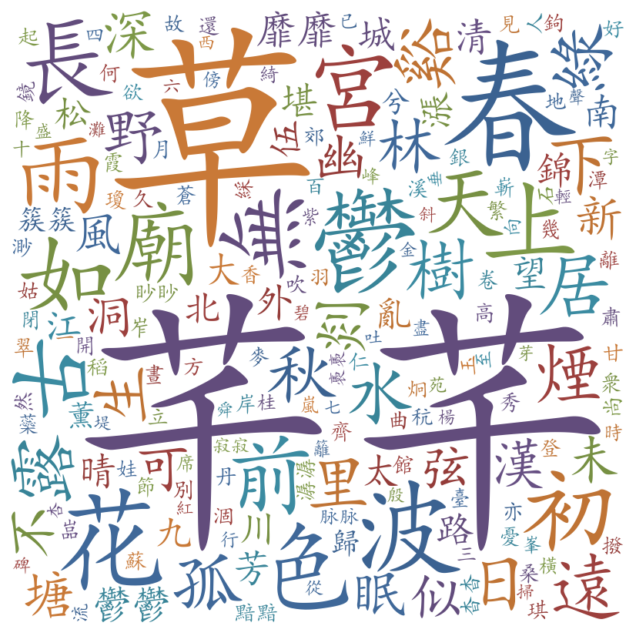

Counter({'芊芊': 40, '草': 27, '春': 7, '波': 4, '鬱': 4, '花': 4, '色': 3, '初': 3, '如': 3, '上': 3, '宮': 3, '長': 3, '雨': 3, '無': 3, '廟': 3, '古': 3, '前': 3, '天': 3, '水': 2, '谿': 2, '綠': 2, '孤': 2, '煙': 2, '遠': 2, '樹': 2, '居': 2, '日': 2, '下': 2, '露': 2, '秋': 2, '林': 2, '里': 2, '野': 2, '剡': 2, '生': 2, '漢': 2, '深': 2, '不': 2, '可': 2, '幽': 2, '眠': 2, '塘': 2, '似': 2, '未': 2, '弦': 2, '新': 2, '洞': 2, '風': 2, '靡靡': 2, '外': 2, '鬱鬱': 2, '松': 2, '亂': 2, '伍': 2, '川': 2, '路': 2, '九': 2, '南': 2, '北': 2, '江': 2, '晴': 2, '城': 2, '大': 2, '錦': 2, '漲': 2, '太': 2, '清': 2, '芳': 2, '堪': 2, '望': 2, '簇簇': 2, '歸': 2, '薰': 2, '兮': 2, '還': 1, '卷': 1, '潭': 1, '涸': 1, '岸': 1, '嶄': 1, '岝': 1, '眇眇': 1, '起': 1, '齊': 1, '故': 1, '何': 1, '欲': 1, '繁': 1, '降': 1, '節': 1, '蒼': 1, '登': 1, '高': 1, '見': 1, '百': 1, '桑': 1, '炯': 1, '翠': 1, '羽': 1, '銀': 1, '衆': 1, '香': 1, '黯黯': 1, '幾': 1, '地': 1, '肅': 1, '丹': 1, '溪': 1, '別': 1, '瓊': 1, '尚': 1, '離': 1, '憂': 1, '亦': 1, '渺': 1, '然': 1, '麥': 1, '秀': 1, '人': 1, '好': 1, '晝': 1, '方': 1, '鏡': 1,

In [43]:
wordcloud('芊芊')

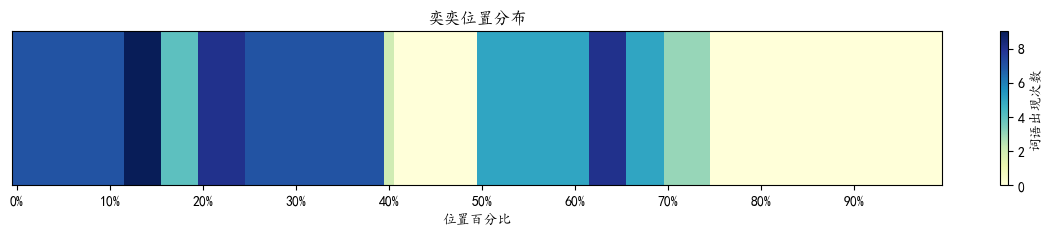

In [12]:
li_position(['奕奕'])

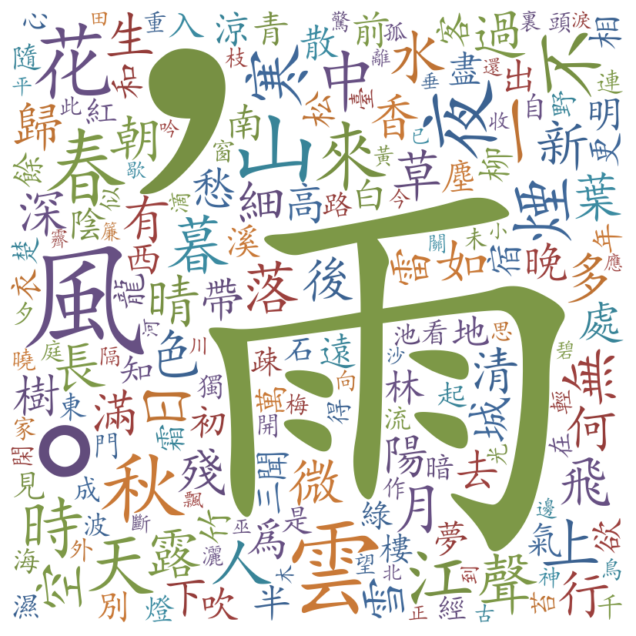

Counter({'，': 6515, '雨': 6406, '。': 6350, '風': 1664, '雲': 1009, '山': 774, '秋': 653, '春': 625, '花': 603, '夜': 589, '不': 509, '天': 484, '來': 462, '江': 454, '一': 442, '煙': 439, '寒': 406, '時': 395, '聲': 377, '中': 373, '日': 353, '暮': 351, '人': 319, '水': 312, '無': 305, '上': 302, '落': 295, '晴': 262, '飛': 260, '露': 255, '長': 252, '新': 249, '微': 247, '月': 243, '空': 240, '過': 240, '行': 236, '如': 235, '多': 229, '草': 228, '色': 226, '細': 222, '歸': 216, '後': 216, '殘': 215, '深': 212, '香': 210, '葉': 210, '朝': 207, '生': 207, '有': 201, '何': 199, '滿': 196, '清': 191, '樹': 190, '雪': 189, '陽': 188, '愁': 184, '城': 183, '晚': 179, '帶': 179, '處': 175, '下': 174, '爲': 174, '高': 173, '去': 172, '雷': 170, '林': 170, '南': 163, '半': 158, '前': 157, '吹': 156, '散': 155, '涼': 155, '青': 152, '入': 152, '白': 151, '出': 150, '初': 149, '松': 149, '明': 148, '地': 148, '西': 147, '陰': 146, '竹': 146, '盡': 146, '遠': 145, '宿': 145, '夢': 144, '溪': 144, '氣': 143, '柳': 143, '客': 142, '和': 141, '相': 141, '聞': 140, '欲': 140, '龍': 139, '更': 1

In [20]:
# 统计任意一些词的共现


wordlist = ["雨"]
wordslines = []
for word in wordlist:
    for line in tokenized_corpus:
        jiaoji = len(set(line) & set(wordlist))
        if jiaoji == len(wordlist):
            wordslines = wordslines + line
            
from collections import Counter
wordslines_counter = Counter(wordslines)

font_path = r'C:\Windows\Fonts\simkai.ttf'
# 自定义颜色函数
def custom_color_func(word, font_size, position, orientation, random_state, **kwargs):
    color_list = ['#3b6291', '#943c39', '#779043', '#624c7c','#388498', '#bf7334', '#3f6899', '#9c403d', '#7d9847', '#675083', '#3b8ba1', '#c97937']
    random_color = random.choice(color_list)

    return random_color  # 自定义16进制颜色码


# 创建词云对象
wordcloud = WordCloud(width=800, height=800,font_path=font_path, background_color='white',color_func=custom_color_func).generate_from_frequencies(wordslines_counter)

# 绘制词云
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 关闭坐标轴
plt.show()
print(wordslines_counter)


for k,v in wordslines_counter.items():
    if len(k) == 2:
        print(k,v)

In [30]:
lookup_quanwen('咽咽陰蟲叫')

咽咽陰蟲叫共1句。如下
“咽咽陰蟲叫，蕭蕭寒鴈來”（馬戴《田氏南樓對月》）


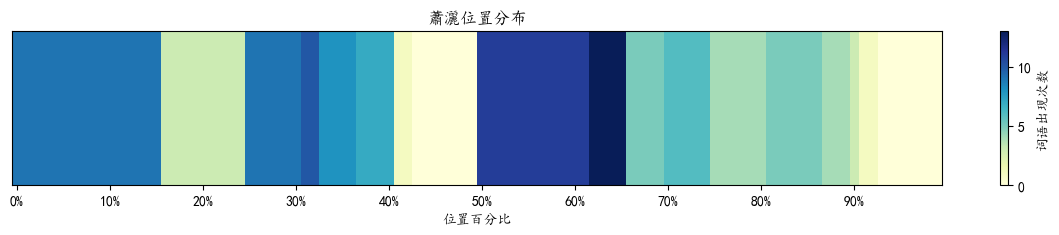

In [42]:
# 统计非重言词的位置分布
word = '蕭灑'
wordlines = []
position_vector = np.zeros(100)
for poet in qtsdata:
    for line in poet['paragraphs']:
        if word in line:
            wordlines.append(line)
            
for sentence in wordlines:
    if word in sentence:
        start_position = sentence.index(word)
        end_position = start_position + len(word)
        start_percent = start_position / len(sentence) * 100
        end_percent = end_position / len(sentence) * 100
        position_vector[int(start_percent):int(end_percent)] += 1
            
# 使用Matplotlib绘制热力图
plt.figure(figsize=(15, 2))
plt.imshow(position_vector.reshape(1, -1), cmap="YlGnBu", aspect="auto")
plt.colorbar(label="词语出现次数")
plt.xlabel("位置百分比")
plt.title(f"{word}位置分布")
plt.xticks(range(0, 100, 10), [f"{i}%" for i in range(0, 100, 10)])
plt.yticks([])  # 隐藏Y轴
plt.savefig(f"output/pospic/{word}位置分布.png",dpi=300)
plt.show()

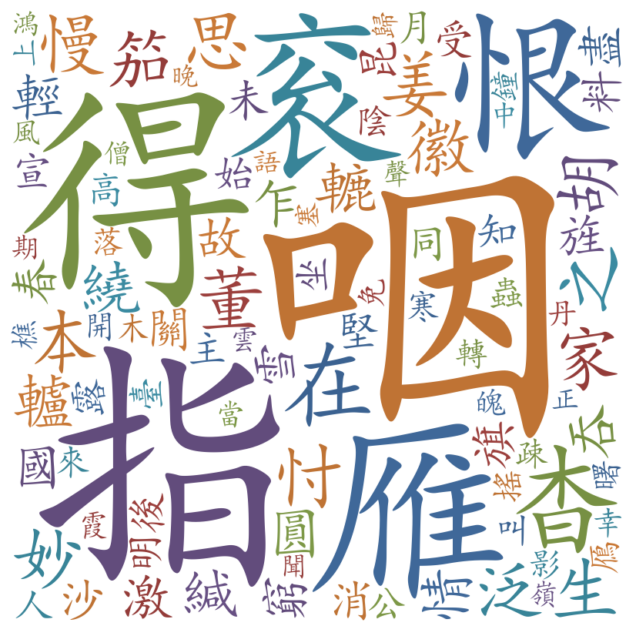

Counter({'咽': 3, '指': 2, '得': 2, '雁': 2, '衮': 2, '恨': 2, '杳': 2, '在': 2, '笳': 1, '慢': 1, '董': 1, '家': 1, '本': 1, '姜': 1, '生': 1, '之': 1, '妙': 1, '思': 1, '忖': 1, '泛': 1, '徽': 1, '胡': 1, '繞': 1, '轆': 1, '轤': 1, '圓': 1, '吞': 1, '緘': 1, '情': 1, '乍': 1, '輕': 1, '激': 1, '故': 1, '國': 1, '關': 1, '旌': 1, '旗': 1, '春': 1, '盡': 1, '窮': 1, '沙': 1, '雪': 1, '未': 1, '消': 1, '料': 1, '堅': 1, '昆': 1, '受': 1, '宣': 1, '後': 1, '始': 1, '知': 1, '公': 1, '主': 1, '人': 1, '同': 1, '露': 1, '坐': 1, '明': 1, '月': 1, '高': 1, '臺': 1, '陰': 1, '蟲': 1, '叫': 1, '寒': 1, '鴈': 1, '來': 1, '影': 1, '搖': 1, '疎': 1, '木': 1, '落': 1, '魄': 1, '轉': 1, '曙': 1, '鐘': 1, '開': 1, '幸': 1, '免': 1, '丹': 1, '霞': 1, '風': 1, '樵': 1, '聲': 1, '當': 1, '嶺': 1, '上': 1, '僧': 1, '語': 1, '雲': 1, '中': 1, '正': 1, '歸': 1, '期': 1, '晚': 1, '聞': 1, '塞': 1, '鴻': 1})


In [15]:
# 统计本地文件中的共現

wordslines = []
with open('static/lines.txt','r',encoding='utf-8') as f:
    for line in f.readlines():
        line =line.replace('[',"").replace(']','').replace('\n',"")
        for i in line:
            if i not in ['，','。','蕭']:
                wordslines.append(i)
    
    
            
from collections import Counter
wordslines_counter = Counter(wordslines)

font_path = r'C:\Windows\Fonts\simkai.ttf'
# 自定义颜色函数
def custom_color_func(word, font_size, position, orientation, random_state, **kwargs):
    color_list = ['#3b6291', '#943c39', '#779043', '#624c7c','#388498', '#bf7334', '#3f6899', '#9c403d', '#7d9847', '#675083', '#3b8ba1', '#c97937']
    random_color = random.choice(color_list)

    return random_color  # 自定义16进制颜色码


# 创建词云对象
wordcloud = WordCloud(width=800, height=800,font_path=font_path, background_color='white',color_func=custom_color_func).generate_from_frequencies(wordslines_counter)

# 绘制词云
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 关闭坐标轴
plt.show()
print(wordslines_counter)

In [16]:
lookup_quanwen('雨')

漸漸共40句。如下
“岑霞漸漸落，溪陰寸寸生”（太宗皇帝《賦得白日半西山》）
“麥漸漸，雉子斑”（王維《送李睢陽》）
“凝霜漸漸水，庭橘似懸金”（孟浩然《庭橘》）
“鄉關殊可望，漸漸入吳音”（顧況《南歸》）
“中宵倚牆立，淫淚何漸漸”（韓愈《苦寒》）
“更憐晴日色，漸漸暖貧居”（張籍《早春病中》）
“向南漸漸雲山好，一路唯聞唱竹枝”（張籍《送枝江劉明府》）
“初時天山之外飛白雪，漸漸萬丈澗地生流泉”（盧仝《聽蕭君姬人彈琴》）
“自言行樂朝朝是，豈料浮生漸漸忙”（元稹《酬哥舒大少府寄同年科第》）
“病嗟酒戶年年減，老覺塵機漸漸深”（元稹《和樂天仇家酒》）
“開元之末姚宋死，朝廷漸漸由妃子”（元稹《連昌宮詞》）
“酒戶年年減，山行漸漸難”（元稹《春遊》）
“牆垣反鎖長安春，樓臺漸漸屬西鄰”（白居易《勸酒》）
“誰知漸漸因緣重，羞見長燃一盞燈”（李涉《再謫夷陵題長樂寺》）
“祗應爲酒微微變，不是因年漸漸生”（姚合《奉和前司封蘇郎中喜嚴常侍蕭給事見訪驚斑鬢之什》）
“燕臺上客意何如，四五年來漸漸疎”（杜牧《寄浙西李判官》）
“馬蹄踏流水，漸漸成塵埃”（劉駕《曲江春霽》）
“不論軒冕及漁樵，性與情違漸漸遙”（李咸用《依韻修睦上人山居十首 四》）
“風催曉雁看看別，雨脅秋蠅漸漸癡”（羅隱《寄韋贍》）
“陸海波濤漸漸深，一迴歸夢抵千金”（羅隱《歸夢》）
“看看水沒來時路，漸漸雲藏望處山”（杜荀鶴《春日登樓遇雨》）
“雲中雞犬無消息，麥秀漸漸徧故墟”（胡宿《淮南王》）
“漸漸見苔青，疎疎遍地生”（齊己《西墅新居》）
“碧雲雁影紛紛去，黃葉蟾聲漸漸無”（齊己《荆門病中寄懷鄉人歐陽侍郎彬》）
“徐徐東海出，漸漸上天衢”（南唐失名僧《月》）
“水中白雪微微結，火裏金蓮漸漸生”（呂巖《七言 九》）
“浴就微微白，燒成漸漸紅”（呂巖《五言 十二》）
“人家不中物，漸漸逼他來”（張鷟《詩一首》）
“流光漸漸到華髪，離恨蕭蕭生白蘋”（張祜《長安感懷》）
“家中漸漸貧，良由慵懶婦”（缺名《五言白話詩 五》）
“長命得八十，漸漸無意智”（缺名《五言詩 四》）
“迢迢東海出，漸漸入雲衢”（謙明《中秋詠月（詠詩後，乘興遂子夜鳴鐘，烈祖聞之，不罪也。召問其所求，唯願鵝生四脚，鼈著兩裙。）》）
“孤峰絕頂萬餘嶒，策杖攀蘿漸漸登”（玄奘《題中嶽山七言（在京南）》）
“罪根漸漸深，命絕何人送”（王梵志《詩（幷序

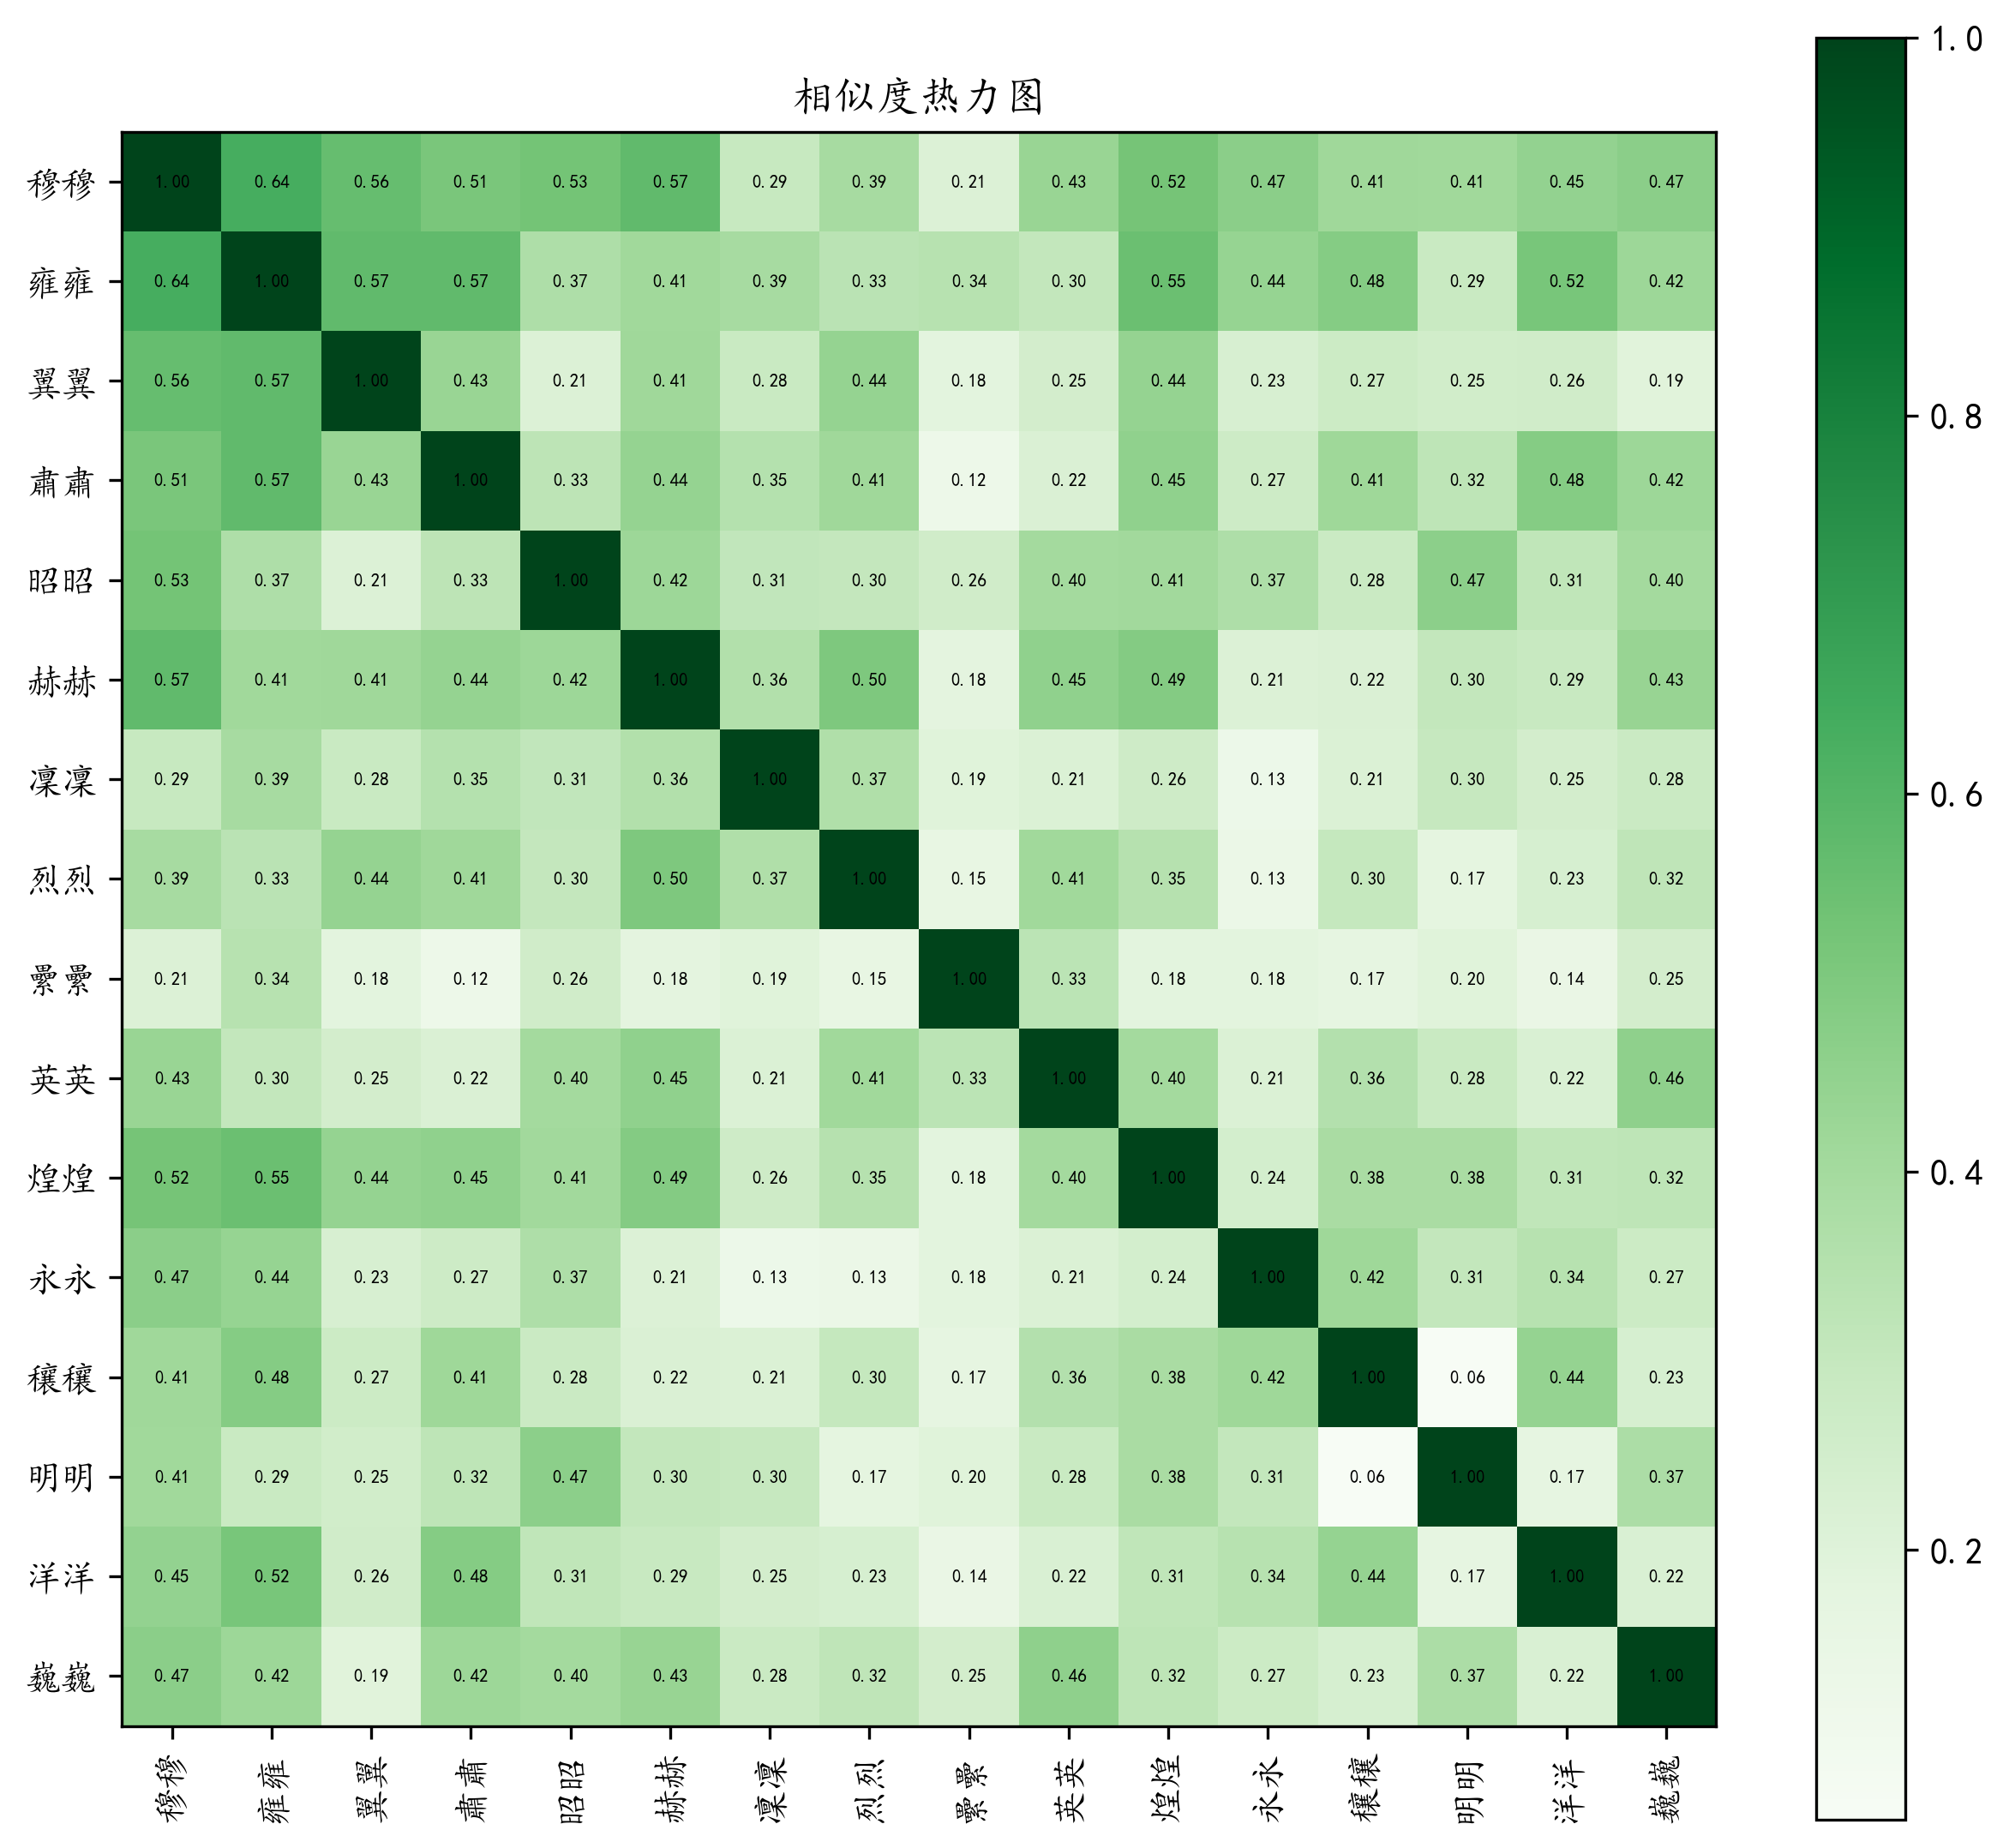

In [20]:
duibili = [x[0] for x in near_c('皇皇')]
hotmap(duibili,'Greens',title='相似度热力图')

In [25]:
len(cy_set)

252

In [27]:
len(duibili )


13

In [26]:
import numpy as np

# 初始化相似度总和和计数器
total_similarity = 0.0
count = 0

# 迭代所有词并计算相似度
for word1 in cy_set:
    for word2 in cy_set:
        if word1 != word2:  # 避免计算词与自己的相似度
            similarity = emb.similarity(word1, word2)
            total_similarity += similarity
            count += 1

# 计算平均相似度
average_similarity = total_similarity / count

print(count,f"重言詞平均相似度: {average_similarity}")

63252 重言詞平均相似度: 0.18574809215308938


In [24]:
import numpy as np

# 初始化相似度总和和计数器
total_similarity = 0.0
count = 0

# 迭代所有词并计算相似度
for word1 in duibili:
    for word2 in duibili:
        if word1 != word2:  # 避免计算词与自己的相似度
            similarity = emb.similarity(word1, word2)
            total_similarity += similarity
            count += 1

# 计算平均相似度
average_similarity = total_similarity / count

print(count,f"重言詞平均相似度: {average_similarity}")

156 重言詞平均相似度: 0.40861623218426335
